<a href="https://colab.research.google.com/github/pengchengyu0125/Risk-Analysis-For-World-Vision/blob/main/project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics

In [ ]:
pip install scikit-learn-extra

In [ ]:
# Read data
financial = pd.read_excel('sample_data/financial data.xlsx')
beneficiary = pd.read_excel('sample_data/beneficiary data.xlsx')
program = pd.read_excel('sample_data/program results data.xlsx')

In [ ]:
# Read financial data
financial = financial[:27824]

In [ ]:
# Count the missing values in financial data
financial.isnull().any()
financial.isnull().sum()

Year              0
Project           0
Month             0
Period Budget     0
Period Actual    26
Difference        0
dtype: int64

In [ ]:
# Fill Period Actual data using the average
financial['Period Actual'] = financial['Period Actual'].fillna(value = financial['Period Actual'].mean())
financial.isnull().any()
financial.isnull().sum()

Year             0
Project          0
Month            0
Period Budget    0
Period Actual    0
Difference       0
dtype: int64

In [ ]:
# Count the missing values in beneficiary data
beneficiary.isnull().any()
beneficiary.isnull().sum()

Project         0
Year           50
FY              0
Age Group      73
Sex            51
Target       1455
Achieved       78
dtype: int64

In [ ]:
# Delete Target and Achieved data with null value
beneficiary = beneficiary.dropna(axis = 0, subset = ['Target', 'Achieved'])
beneficiary.isnull().any()
beneficiary.isnull().sum()

Project       0
Year          3
FY            0
Age Group    23
Sex           1
Target        0
Achieved      0
dtype: int64

In [ ]:
# observe financial data and edit date format
financial['Month'] = financial['Month'].replace(regex={r'January': 1, 'February': 2, 'March': 3, 'April': 4, 'May': 5, 'June': 6, 'July': 7, 'August': 8, 'September': 9, 'October': 10, 'November': 11, 'December': 12})
financial['Year'] = financial['Year'].astype('str')
financial['Month'] = financial['Month'].astype('str')
financial['Date'] = financial['Year'] + "-" + financial['Month']
project1 = financial[financial['Project'] == 'Project 66']
project1.index = project1['Date']

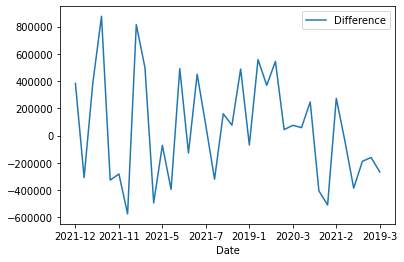

In [ ]:
line = pd.DataFrame(project1['Difference'])
line.plot()

In [ ]:
# Combine data belonging to the same project together
fp = financial['Project'].drop_duplicates(keep='first', inplace=False)
fp = fp.reset_index()
financial_data = pd.DataFrame(index=range(len(fp)))
financial_data['Project'] = fp['Project']
# Create two new fields, the first indicates the percentage of times the budget was exceeded in a project
# the second indicates the percentage of the total budget amount that was over budget
financial_data['Overbudget_ratio'] = None
financial_data['Negative_difference_ratio'] = None

In [ ]:
# Calculate the data in those fields
j = 0
for i in range(len(financial_data)):
  over_budget = 0
  sum = 0
  budget_sum = 0
  negative_sum = 0
  while j in range(len(financial)):
    if financial_data['Project'][i] != financial['Project'][j] or j == len(financial) - 1:
      financial_data['Overbudget_ratio'][i] = over_budget / sum
      financial_data['Negative_difference_ratio'][i] = negative_sum / budget_sum
      break
    else:
      if financial['Difference'][j] < 0:
        over_budget += 1
        negative_sum += -financial['Difference'][j]
      sum += 1
      budget_sum += financial['Period Budget'][j]
      j += 1

In [ ]:
# Combine data belonging to the same project together
bp = beneficiary['Project'].drop_duplicates(keep='first', inplace=False)
bp = bp.reset_index()
beneficiary_data = pd.DataFrame(index=range(len(bp)))
beneficiary_data['Project'] = bp['Project']
# Create two new fields, the first indicates the percentage of times the result was not achieved
# the second indicates the percentage of the number of non-achievements
beneficiary_data['Not_achieved_times'] = None
beneficiary_data['Not_achieved_ratio'] = None
beneficiary = beneficiary.reset_index()

In [ ]:
# Calculate the data in those fields
for i in range(len(beneficiary_data)):
  not_times = 0
  sum = 0
  not_sum = 0
  target_sum = 0
  for j in range(len(beneficiary)):
    if beneficiary_data['Project'][i] == beneficiary['Project'][j]:
      if beneficiary['Achieved'][j] < beneficiary['Target'][j]:
        not_times += 1
        not_sum += beneficiary['Target'][j] - beneficiary['Achieved'][j]
      sum += 1
      target_sum += beneficiary['Target'][j]
  beneficiary_data['Not_achieved_times'][i] = not_times / sum
  beneficiary_data['Not_achieved_ratio'][i] = not_sum / target_sum

In [ ]:
# Merge data from two tables based on Project field
cluster_data = pd.merge(financial_data,beneficiary_data,on='Project')

In [ ]:
# Use Project field as index
cluster_data.set_index(["Project"], inplace=True)

In [ ]:
# Use KMedoids algorithm to cluster the data into two classes
from sklearn_extra.cluster import KMedoids
from sklearn.cluster import KMeans
k = 2
iteration = 500
# model_KMeans = KMeans(n_clusters=k, init='random', max_iter=iteration)
kmedoids = KMedoids(n_clusters=k, init='random', max_iter=iteration)
# model_KMeans.fit(cluster_data)
kmedoids.fit(cluster_data)

KMedoids(init='random', max_iter=500, n_clusters=2)

In [ ]:
# Get class labels
r1 = pd.Series(kmedoids.labels_).value_counts()
r2 = pd.DataFrame(kmedoids.cluster_centers_)
r = pd.concat([r2,r1], axis=1)
r.colums = list(cluster_data.columns) + ['Category Sample Size']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  """


In [ ]:
results_km = pd.concat([cluster_data, pd.Series(kmedoids.labels_, index = cluster_data.index)], axis=1)
results_km.columns = list(cluster_data.columns) + ['Category']
results_km

,Overbudget_ratio,Negative_difference_ratio,Not_achieved_times,Not_achieved_ratio,Category
Project,,,,,
Project 106,0.388889,0.25666,0.0,0.0,0
Project 114,0.416667,0.257141,0.0,0.0,0
Project 157,0.416667,0.163503,0.0,0.0,0
Project 200,0.444444,0.243082,0.0,0.0,0
Project 208,0.333333,0.213774,0.0,0.0,0
...,...,...,...,...,...
Project 781,0.416667,0.213093,1.0,0.763425,1
Project 782,0.361111,0.231654,1.0,0.733316,1
Project 783,0.472222,0.265706,1.0,0.031489,1


In [ ]:
# Read data from these fields only
program_sub = program.loc[:, ['Project', 'Sector', 'Benefit Category', 'Intervention Category', 'Age_Group', 'Disaggregation']]

In [ ]:
# Add label information obtained by clustering
program_data = pd.merge(program_sub,results_km['Category'],on='Project')

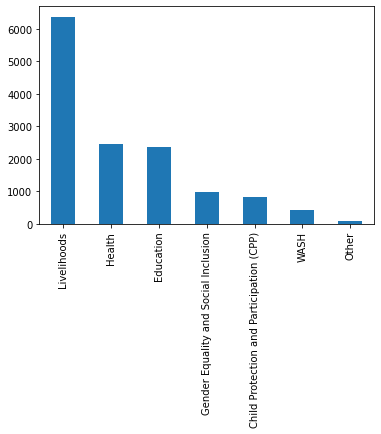

In [ ]:
# Observation of data in project marked as risky
program_data[program_data.Category==1]['Sector'].value_counts().plot.bar()

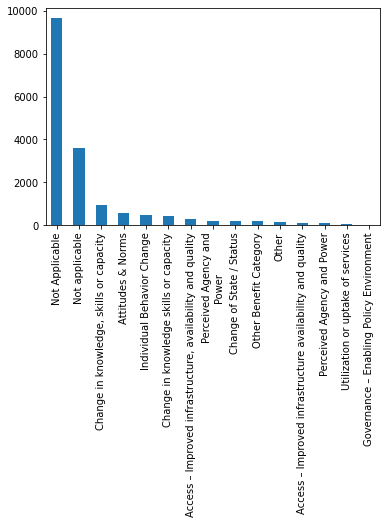

In [ ]:
program_data[program_data.Category==1]['Benefit Category'].value_counts().plot.bar()

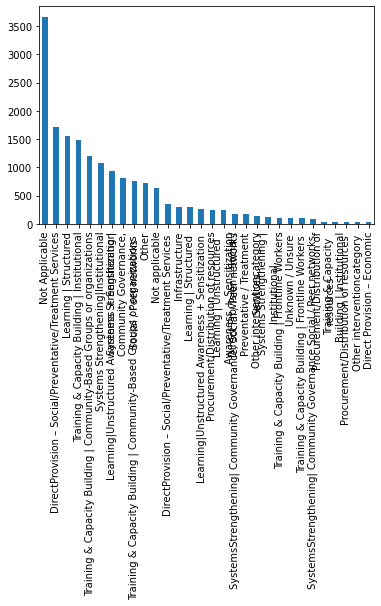

In [ ]:
program_data[program_data.Category==1]['Intervention Category'].value_counts().plot.bar()

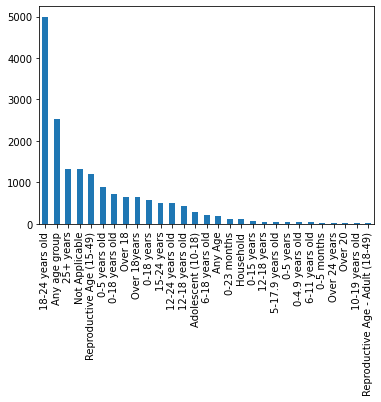

In [ ]:
program_data[program_data.Category==1]['Age_Group'].value_counts().plot.bar()

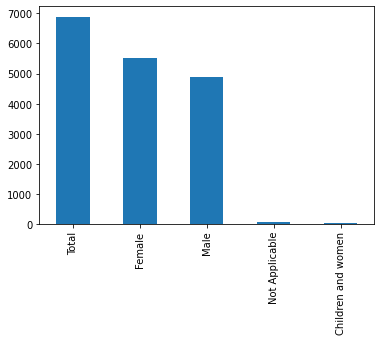

In [ ]:
program_data[program_data.Category==1]['Disaggregation'].value_counts().plot.bar()

In [ ]:
# Normalize data
program_data['Sector'].replace('Livelihoods',1,inplace=True)
program_data['Sector'].replace('Health',2,inplace=True)
program_data['Sector'].replace('Education',3,inplace=True)
program_data['Sector'].replace('Child Protection and Participation (CPP)',4,inplace=True)
program_data['Sector'].replace('WASH',5,inplace=True)
program_data['Sector'].replace('Gender Equality and Social Inclusion',6,inplace=True)
program_data['Sector'].replace(['Other',0],7,inplace=True)

In [ ]:
program_data['Benefit Category'].replace(['Not Applicable (resource) ','Not Applicable','Not applicable'],0,inplace=True)
program_data['Benefit Category'].replace(['Access – Improved infrastructure, availability and quality','Access – Improved infrastructure availability and quality','Access – Improved infrastructure, availability and quality'],2,inplace=True)
program_data['Benefit Category'].replace(['Attitudes & Norms'],3,inplace=True)
program_data['Benefit Category'].replace(['Change in knowledge skills or capacity','Change in knowledge, skills or capacity','Change in knowledge, skills'],4,inplace=True)
program_data['Benefit Category'].replace(['Change of State / Status'],5,inplace=True)
program_data['Benefit Category'].replace(['Governance – Enabling Policy Environment','Governance – Enabling Policy Environment','Governance - Monitoring & Accountability'],6,inplace=True)
program_data['Benefit Category'].replace(['Individual Behavior Change','Individual Behavior Change'],7,inplace=True)
program_data['Benefit Category'].replace(['Other','Other Benefit Category'],8,inplace=True)
program_data['Benefit Category'].replace(['Perceived Agency and Power','Perceived Agency and\nPower'],9,inplace=True)
program_data['Benefit Category'].replace(['Utilization or uptake of services','Utilization or uptake of\nservices'],1,inplace=True)

In [ ]:
program_data['Intervention Category'].replace(['DirectProvision – Social/Preventative/Treatment Services','DirectProvision – Social/Preventative/Treatment Services ','Direct Provision – Social /\nPreventative / Treatment\nServices','Direct Provision – Food + Cash','Direct Provision – Food +\nCash','Direct Provision – Food + Cash ','Direct Provision – Economic','Direct Provision – Economic '],1,inplace=True)
program_data['Intervention Category'].replace(['Infrastructure','Infrastructure '],2,inplace=True)
program_data['Intervention Category'].replace(['Learning|Unstructured Awareness + Sensitization','Learning | Structured','Learning|Unstructured Awareness + Sensitization ','Learning | Structured ','Learning | Unstructured\nAwareness + Sensitization','Learning | Mass Media\nSensitization'],3,inplace=True)
program_data['Intervention Category'].replace(['Not Applicable','Not applicable','Unknown / Unsure '],0,inplace=True)
program_data['Intervention Category'].replace(['Other','Other interventioncategory','Other interventioncategory '],4,inplace=True)
program_data['Intervention Category'].replace(['Procurement/Distribution of resources','Procurement/Distribution of resources ','Procurment / Distribution of resources','Procurement/Distribution of\nresources'],5,inplace=True)
program_data['Intervention Category'].replace(['Systems Strengthening|Institutional','Systems Strengthening |\nCommunity Governance,\nSocial / Peer networks','SystemsStrengthening| Community Governance, Social / Peer networks','SystemsStrengthening| Community Governance Social / Peer networks ','Systems Strengthening |\nInstitutional','Systems Strengthening|Institutional '],6,inplace=True)
program_data['Intervention Category'].replace(['Training & Capacity Building | Community-Based Groups or organizations','Training & Capacity Building | Community-Based Groups or organizations ','Training & Capacity Building | Institutional','Training & Capacity Building | Frontline Workers','Training & Capacity Building | Frontline Workers ','Training & Capacity Building | Institutional ','Training & Capacity\nBuilding | Institutional'],7,inplace=True)

In [ ]:
program_data['Age_Group'].replace(['0-18 years old','0-5 years old','6-18 years old','0-18 years','12-18 years old','Adolescent (10-18)','0-23 months','0-5 years','0-6 months','6-11 years','0-15 years','Children ( 0-18)','12-18 years','5-17.9 years old','0-4.9 years old','Adolescent Reproductive Age (15-18)','6-59 months','6-11 years old','0-5','12-23 months','0-5 months','10-19 years old','18-24 years old','12-24 years old','15-24 years','12-24 years'],1,inplace=True)
program_data['Age_Group'].replace(['Over 18years','Over 18','25+ years','Over 18 years','Reproductive Age - Adult (18-49)','Over 24 years','Over 20'],2,inplace=True)
program_data['Age_Group'].replace(['Not Applicable','Not applicable'],0,inplace=True)
program_data['Age_Group'].replace(['Any age group','Reproductive Age (15-49)','Household','Any Age'],3,inplace=True)

In [ ]:
program_data['Disaggregation'].replace(['Not Applicable'],0,inplace=True)
program_data['Disaggregation'].replace(['Female','Children and women'],2,inplace=True)
program_data['Disaggregation'].replace(['Male'],1,inplace=True)
program_data['Disaggregation'].replace(['Total'],3,inplace=True)

In [ ]:
# Processing of missing values in this dataset
sector_count = program_data['Sector'].value_counts()
sector_ratio = pd.DataFrame(index=range(1,len(sector_count)+1))
sector_ratio['Ratio'] = None
sum = program_data['Sector'].value_counts().sum()
for i in range(len(sector_count)):
  sector_ratio['Ratio'][i+1] = sector_count[i + 1] / sum
program_data['Sector'] = program_data['Sector'].fillna(pd.Series(np.random.choice(list(sector_ratio.index), p=sector_ratio['Ratio'], size=len(program_data))))

In [ ]:
benefit_category_count = program_data['Benefit Category'].value_counts()
benefit_category_ratio = pd.DataFrame(index=range(len(benefit_category_count)))
benefit_category_ratio['Ratio'] = None
sum = program_data['Benefit Category'].value_counts().sum()
for i in range(len(benefit_category_count)):
  benefit_category_ratio['Ratio'][i] = benefit_category_count[i] / sum
program_data['Benefit Category'] = program_data['Benefit Category'].fillna(pd.Series(np.random.choice(list(benefit_category_ratio.index), p=benefit_category_ratio['Ratio'], size=len(program_data))))

In [ ]:
intervention_category_count = program_data['Intervention Category'].value_counts()
intervention_category_ratio = pd.DataFrame(index=range(len(intervention_category_count)))
intervention_category_ratio['Ratio'] = None
sum = program_data['Intervention Category'].value_counts().sum()
for i in range(len(intervention_category_count)):
  intervention_category_ratio['Ratio'][i] = intervention_category_count[i] / sum
program_data['Intervention Category'] = program_data['Intervention Category'].fillna(pd.Series(np.random.choice(list(intervention_category_ratio.index), p=intervention_category_ratio['Ratio'], size=len(program_data))))

In [ ]:
age_count = program_data['Age_Group'].value_counts()
age_ratio = pd.DataFrame(index=range(len(age_count)))
age_ratio['Ratio'] = None
sum = program_data['Age_Group'].value_counts().sum()
for i in range(len(age_count)):
  age_ratio['Ratio'][i] = age_count[i] / sum
program_data['Age_Group'] = program_data['Age_Group'].fillna(pd.Series(np.random.choice(list(age_ratio.index), p=age_ratio['Ratio'], size=len(program_data))))

In [ ]:
disaggregation_count = program_data['Disaggregation'].value_counts()
disaggregation_ratio = pd.DataFrame(index=range(len(disaggregation_count)))
disaggregation_ratio['Ratio'] = None
sum = program_data['Disaggregation'].value_counts().sum()
for i in range(len(disaggregation_count)):
  disaggregation_ratio['Ratio'][i] = disaggregation_count[i] / sum
program_data['Disaggregation'] = program_data['Disaggregation'].fillna(pd.Series(np.random.choice(list(disaggregation_ratio.index), p=disaggregation_ratio['Ratio'], size=len(program_data))))

In [ ]:
program_data.isnull().sum()

Project                  0
Sector                   0
Benefit Category         0
Intervention Category    0
Age_Group                0
Disaggregation           0
Category                 0
dtype: int64

In [ ]:
# Analyzing the importance of different attributes using the random forest algorithm
from sklearn.ensemble import RandomForestClassifier 
x_val = program_data.loc[:,['Sector','Benefit Category','Intervention Category','Age_Group','Disaggregation']]
y_val = program_data.loc[:,'Category']
clf = RandomForestClassifier(n_estimators=100,random_state=123)
clf.fit(x_val, y_val)
print(clf.feature_importances_)

[0.17748055 0.09628227 0.5035746  0.15756872 0.06509386]


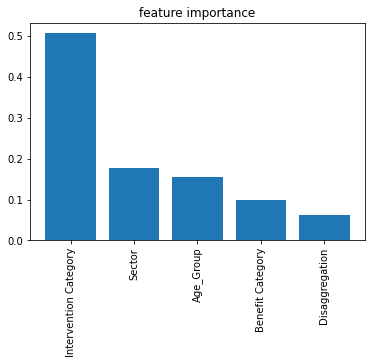

In [ ]:
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]

feature_names = ['Sector','Benefit Category','Intervention Category','Age_Group','Disaggregation']
names = [feature_names[i] for i in indices]

plt.figure()
plt.title("feature importance")

plt.bar(range(x_val.shape[1]), importances[indices])
plt.xticks(range(x_val.shape[1]), names, rotation=90)
plt.show()

In [ ]:
# Training and prediction of data using Random Forest algorithm
from sklearn.model_selection import train_test_split

x = program_data.loc[:,['Sector','Benefit Category','Intervention Category','Age_Group','Disaggregation']]
y = program_data.loc[:,'Category']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)
clf=RandomForestClassifier(n_estimators=100,random_state=16) 
clf.fit(x_train, y_train)

RandomForestClassifier(random_state=16)

In [ ]:
from sklearn.metrics import classification_report 
print(classification_report(y_test,clf.predict(x_test)))

              precision    recall  f1-score   support

           0       0.90      0.88      0.89      4653
           1       0.85      0.87      0.86      3593

    accuracy                           0.88      8246
   macro avg       0.87      0.88      0.88      8246
weighted avg       0.88      0.88      0.88      8246



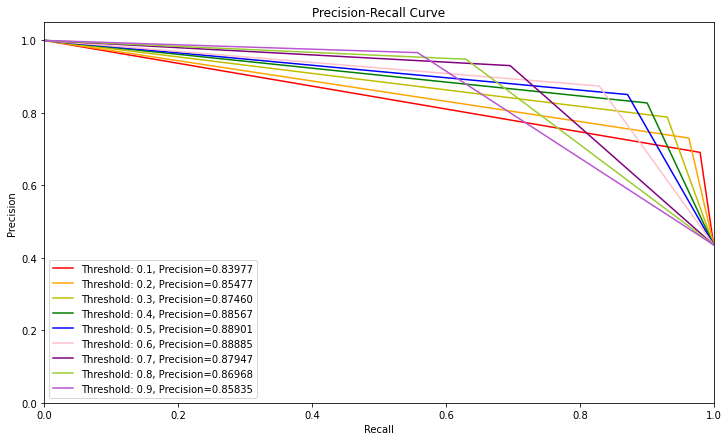

In [ ]:
from itertools import cycle 
from sklearn.metrics import precision_recall_curve,auc 
thresholds = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9] 
colors = cycle(['r','orange','y','g','blue','pink','purple','yellowgreen','mediumorchid']) 
plt.figure(figsize=(12,7)) 
j = 1 
y_pred_proba = clf.predict_proba(x_test) 
for i,color in zip(thresholds,colors): 
  y_test_predictions_prob = y_pred_proba[:,1] > i 

  precision, recall, thresholds = precision_recall_curve(y_test, y_test_predictions_prob) 
  area = auc(recall, precision)
  plt.plot(recall, precision, color=color,label='Threshold: %s, Precision=%0.5f' %(i , area)) 
  plt.xlabel('Recall') 
  plt.ylabel('Precision') 
  plt.ylim([0.0, 1.05]) 
  plt.xlim([0.0, 1.0]) 
  plt.title('Precision-Recall Curve') 
  plt.legend(loc="lower left")

In [ ]:
# Training and prediction of data using Neural Network algorithm
from sklearn.neural_network import MLPClassifier

In [ ]:
mlp = MLPClassifier(hidden_layer_sizes=(20,20,20), max_iter=500)
mlp.fit(x_train,y_train)
prediction = mlp.predict(x_test)

In [ ]:
print("score:",mlp.score(x_test,y_test))
print("precision_score:",metrics.precision_score(y_test,prediction))
print("recall_score:",metrics.recall_score(y_test,prediction))
print("f1_score:",metrics.f1_score(y_test,prediction))

score: 0.8535047295658501
precision_score: 0.8284219223354448
recall_score: 0.8371834121903702
f1_score: 0.832779623477298


In [ ]:
# Training and prediction of data using SVM
from sklearn import svm
slf = svm.SVR()
slf.fit(x_train,y_train)
sPrediction = slf.predict(x_test)

In [ ]:
for i in range(len(sPrediction)):
  if sPrediction[i] >= 0.5:
    sPrediction[i] = 1
  else:
    sPrediction[i] = 0
print("score:",slf.score(x_test,y_test))
print("precision_score:",metrics.accuracy_score(y_test,sPrediction))
print("recall_score:",metrics.recall_score(y_test,sPrediction))
print("f1_score:",metrics.f1_score(y_test,sPrediction))

score: 0.4409947014983323
precision_score: 0.8154256609265098
recall_score: 0.8508210409128861
f1_score: 0.8006809848088005
